In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from joblib import dump

In [2]:
train_df = pd.read_csv('train.csv')
print(train_df.head())

         lat  feature_9  feature_32  feature_41  feature_48  feature_65  \
0  47.363091   0.645621    0.684492    0.725729    0.532188    0.748397   
1  41.247622   0.725057    0.156720    0.571495    0.510533    0.339930   
2  50.372403   0.666771    0.428295    0.837618    0.292926    0.969829   
3  47.378004   0.645621    0.684492    0.725729    0.532188    0.748397   
4  54.406730   0.794982    0.485213    0.329114    0.926661    0.791215   

   feature_69  feature_72  feature_89  feature_90  ...  feature_197  \
0    0.895157    0.061549    0.316922    0.212827  ...     0.739310   
1    0.663991    0.855951    0.588857    0.452358  ...     0.550212   
2    0.446264    0.947559    0.322451    0.288618  ...     0.562044   
3    0.895157    0.061549    0.316922    0.212827  ...     0.739310   
4    0.328090    0.896639    0.740668    0.362391  ...     0.592237   

   feature_224  feature_238  feature_248  feature_263  feature_312  id  \
0     0.439354     0.283354     0.063036     0.4

Посмотрим как распределены признаки. Построим гистограммы каждой величины.

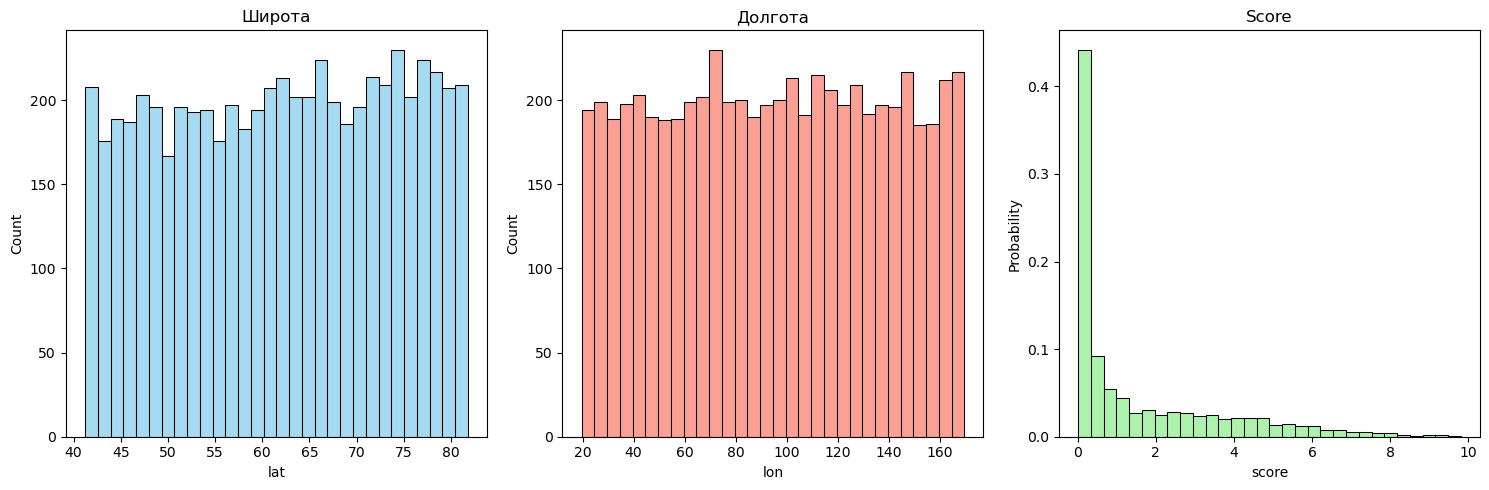

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(train_df['lat'], bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Широта')

sns.histplot(train_df['lon'], bins=30, ax=axes[1], color='salmon')
axes[1].set_title('Долгота')

sns.histplot(train_df['score'], bins=30, ax=axes[2], color='lightgreen', stat='probability')
axes[2].set_title('Score')

plt.tight_layout()
plt.show()

In [4]:
X = train_df.drop(labels=['score', 'id'], axis=1)
y= train_df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Используем модель LightGBM из-за её быстроты и высокой производительности. Подберем параметры через поиск по сетке.

In [5]:
lgb_model = lgb.LGBMRegressor(random_state=42)

lgb_params = {
    'max_depth': range(16, 19),
    'num_leaves': range(34, 37),
    'min_child_samples': (17, 20)
}

grid = GridSearchCV(lgb_model, lgb_params, cv=5, n_jobs=4, verbose=True)
grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'max_depth': 18, 'min_child_samples': 17, 'num_leaves': 36}


In [6]:
model = lgb.LGBMRegressor(max_depth=grid.best_params_['max_depth'],
                         min_child_samples=grid.best_params_['min_child_samples'],
                         num_leaves=grid.best_params_['num_leaves'], 
                         n_estimators=1000, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.018615986479618398


Сохраним обученную модель для дальнейшего использования

In [13]:
dump(model, 'model_geo.joblib')

['model_geo.joblib']